In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# CNN (Convolutional) EncoderDecoder

## Installations

In [2]:
# requirements = """
# keras
# git+https://www.github.com/keras-team/keras-contrib.git
# matplotlib
# numpy
# scipy
# pillow
# #urllib
# #skimage
# scikit-image
# #gzip
# #pickle
# """
# %store requirements > requirements.txt

In [3]:
# !pip install -r requirements.txt

## Import TensorFlow and other libraries

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

# !pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
from keras.preprocessing.image import img_to_array, load_img
from random import shuffle
import PIL
import json
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('TKAgg')
%matplotlib inline

Using TensorFlow backend.


## Load the dataset

Steps to generate URL used below:
- Say, your data files are in the directory called 'input'
- Manually create a zip file, 'input.zip'
- Sync it to gDrive
- In gDrive, Share it with Public model, copy its share-able link
- Use https://sites.google.com/site/gdocs2direct/ to generate corresponding Direct link
- Paste it below

In [19]:
# working directory
wdir = os.getcwd()
wdir

'C:\\Continuum\\anaconda3\\envs\\odsc_ws\\notebooks\\MidcurveNN-master'

In [20]:
# _URL = 'https://drive.google.com/uc?export=download&id=16rqDFLO__WySSQGlAht0FEj2uJZg4M9M'

# path_to_zip = tf.keras.utils.get_file('input.zip',
#                                       origin=_URL,
#                                       extract=True)

# input_data_folder = os.path.join(os.path.dirname(path_to_zip), 'input')
input_data_folder = wdir + "\data\input"

In [21]:
def read_input_image_pairs(datafolder=input_data_folder):
    profile_pngs = []
    midcurve_pngs = []
    for file in os.listdir(datafolder):
        fullpath = os.path.join(datafolder, file)
        if os.path.isdir(fullpath):
            continue
        if file.endswith(".png"):
            if file.find("Profile") != -1:
                profile_pngs.append(fullpath)
            if file.find("Midcurve") != -1:
                midcurve_pngs.append(fullpath)
    profile_pngs = sorted(profile_pngs)
    midcurve_pngs = sorted(midcurve_pngs)
    return profile_pngs,midcurve_pngs

In [22]:
def get_training_data(datafolder = input_data_folder):
    profile_pngs,midcurve_pngs = read_input_image_pairs(datafolder)
    
    profile_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(100, 100))) for f in profile_pngs ]
    midcurve_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(100, 100))) for f in midcurve_pngs]

#     profile_pngs_objs = np.array([x.reshape((1,) + x.shape) for x in profile_pngs_objs])
#     midcurve_pngs_objs = np.array([x.reshape((1,) + x.shape) for x in midcurve_pngs_objs])

    profile_pngs_gray_objs = [x[:,:,3] for x in profile_pngs_objs]
    midcurve_pngs_gray_objs =[x[:,:,3] for x in midcurve_pngs_objs]
    
#     profile_pngs_gray_objs = [np.where(x>128, 0, 1) for x in profile_pngs_gray_objs]
#     midcurve_pngs_gray_objs =[np.where(x>128, 0, 1) for x in midcurve_pngs_gray_objs]
        
    # shufle them
    zipped_profiles_midcurves = [(p,m) for p,m in zip(profile_pngs_gray_objs,midcurve_pngs_gray_objs)]
    shuffle(zipped_profiles_midcurves)
    profile_pngs_gray_objs, midcurve_pngs_gray_objs = zip(*zipped_profiles_midcurves)
    
    return profile_pngs_gray_objs, midcurve_pngs_gray_objs

In [23]:
profile_pngs_objs, midcurve_pngs_objs = get_training_data()

In [24]:
def plot_results(original_imgs,computed_imgs):
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_imgs[i].reshape(100, 100),cmap='gray_r')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(computed_imgs[i].reshape(100, 100),cmap='gray_r')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

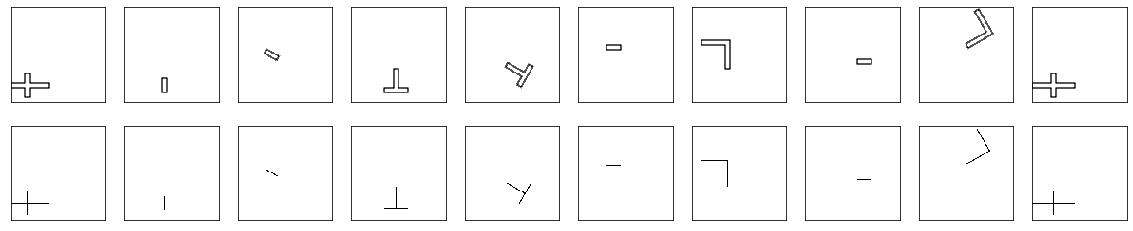

In [25]:
plot_results(profile_pngs_objs,midcurve_pngs_objs)

In [17]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

def build_cnn_autoencoder_model(profile_pngs_gray_objs, midcurve_pngs_gray_objs,encoding_dim = 100, input_dim = 100):
    input_img = Input(shape=(input_dim, input_dim, 1))  # adapt this if using `channels_first` image data format
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    
    # Model 1: Full AutoEncoder, includes both encoder single dense layer and decoder single dense layer. 
    # This model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)
    
    # Compilation of Autoencoder (only)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    
    # Training
    profile_pngs_flat_objs = [x.reshape(input_dim,input_dim,1) for x in profile_pngs_gray_objs]
    midcurve_pngs_flat_objs = [x.reshape(input_dim,input_dim,1) for x in midcurve_pngs_gray_objs]
    
    profile_pngs_objs = np.array(profile_pngs_flat_objs)
    midcurve_pngs_objs= np.array(midcurve_pngs_flat_objs)
    
    train_size = int(len(profile_pngs_objs)*0.7)
    x_train = profile_pngs_objs[:train_size]
    y_train = midcurve_pngs_objs[:train_size]
    x_test = profile_pngs_objs[train_size:]
    y_test = midcurve_pngs_objs[train_size:]
    autoencoder.fit(x_train, y_train,
                epochs=200,
                batch_size=5,
                shuffle=True,
                validation_data=(x_test, y_test))
        
    encoded_imgs = autoencoder.predict(x_test)
    decoded_imgs = autoencoder.predict(encoded_imgs)    
        
    return x_test,decoded_imgs

Train on 313 samples, validate on 135 samples
Epoch 1/200
313/313 [==============================] - 18s 59ms/step - loss: -15.8818 - val_loss: -18.0763
Epoch 2/200
313/313 [==============================] - 9s 28ms/step - loss: -17.2642 - val_loss: -18.2322
Epoch 3/200
313/313 [==============================] - 9s 28ms/step - loss: -17.4052 - val_loss: -18.3614
Epoch 4/200
313/313 [==============================] - 9s 28ms/step - loss: -17.4753 - val_loss: -18.2055
Epoch 5/200
313/313 [==============================] - 9s 29ms/step - loss: -17.5115 - val_loss: -18.4261
Epoch 6/200
313/313 [==============================] - 9s 29ms/step - loss: -17.5336 - val_loss: -18.4744
Epoch 7/200
313/313 [==============================] - 9s 27ms/step - loss: -17.5651 - val_loss: -18.4733
Epoch 8/200
313/313 [==============================] - 9s 28ms/step - loss: -17.6106 - val_loss: -18.4747
Epoch 9/200
313/313 [==============================] - 9s 28ms/step - loss: -17.6189 - val_loss: -18.5265

313/313 [==============================] - 3s 10ms/step - loss: -17.8086 - val_loss: -18.6928
Epoch 78/200
313/313 [==============================] - 3s 10ms/step - loss: -17.8116 - val_loss: -18.7048
Epoch 79/200
313/313 [==============================] - 3s 10ms/step - loss: -17.8195 - val_loss: -18.6962
Epoch 80/200
313/313 [==============================] - 3s 11ms/step - loss: -17.8070 - val_loss: -18.6877
Epoch 81/200
313/313 [==============================] - 3s 10ms/step - loss: -17.7822 - val_loss: -18.6158
Epoch 82/200
313/313 [==============================] - 3s 10ms/step - loss: -17.8070 - val_loss: -18.7073
Epoch 83/200
313/313 [==============================] - 3s 10ms/step - loss: -17.7835 - val_loss: -18.6628
Epoch 84/200
313/313 [==============================] - 3s 11ms/step - loss: -17.8027 - val_loss: -18.6570
Epoch 85/200
313/313 [==============================] - 3s 10ms/step - loss: -17.8093 - val_loss: -18.7166
Epoch 86/200
313/313 [============================

313/313 [==============================] - 3s 10ms/step - loss: -17.7738 - val_loss: -18.6811
Epoch 154/200
313/313 [==============================] - 3s 10ms/step - loss: -17.7254 - val_loss: -16.4488
Epoch 155/200
313/313 [==============================] - 3s 10ms/step - loss: -17.7357 - val_loss: -18.7062
Epoch 156/200
313/313 [==============================] - 3s 10ms/step - loss: -17.7300 - val_loss: -18.6852
Epoch 157/200
313/313 [==============================] - 3s 10ms/step - loss: -17.7838 - val_loss: -18.2119
Epoch 158/200
313/313 [==============================] - 3s 10ms/step - loss: -17.7719 - val_loss: -18.6689
Epoch 159/200
313/313 [==============================] - 3s 11ms/step - loss: -17.7467 - val_loss: -18.7090
Epoch 160/200
313/313 [==============================] - 3s 10ms/step - loss: -17.7811 - val_loss: -18.5846
Epoch 161/200
313/313 [==============================] - 3s 10ms/step - loss: -17.7803 - val_loss: -18.7168
Epoch 162/200
313/313 [===================

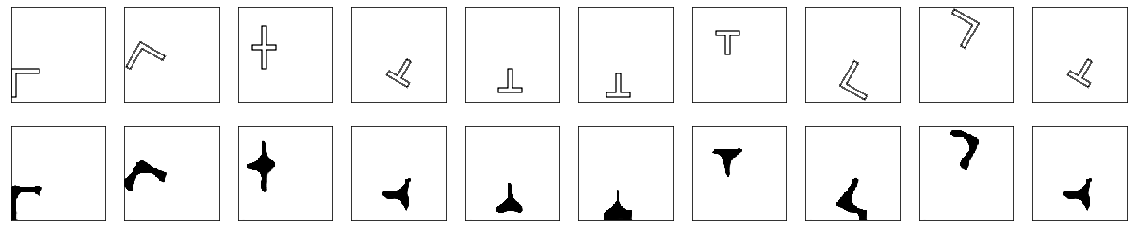

In [18]:
original_imgs,decoded_imgs = build_cnn_autoencoder_model(profile_pngs_objs, midcurve_pngs_objs)
plot_results(original_imgs,decoded_imgs)